#### Learning Objectives

The goals of this notebook are to:
* Explore the FashionMNIST dataset
* Build a U-Net architecture
  * Construct a Down Block
  * Construct an Up Block
* Train a model to remove noise from an image
* Attempt to generate articles of clothing

U-Nets are a type of convolutional neural network that was originally designed for medical imaging. For instance, we could feed the network an image of a heart and it could return a different picture highlighting potentially cancerous areas.

what if we add noise to our images, and then use a U-Net to separate the images from the noise. Could we then feed the model noise and have it create a recognizable image? Let's give it a try!

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [3]:
# for windows check !nvidia-smi

In [4]:
# with mac it shows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

# U-net architecture

#### First, let's define the different components of our U-Net architecture. Primarily, the `DownBlock` and the `UpBlock`.

### The Down Block

The `DownBlock` is a typical convolutional neural network. If you are new to PyTorch and are coming from a Keras/TensorFlow background, the below is more similar to the [functional API](https://keras.io/guides/functional_api/) instead of a [sequential model](https://keras.io/guides/sequential_model/). We will later be using [residual](https://stats.stackexchange.com/questions/321054/what-are-residual-connections-in-rnns) and skip connections. A sequential model does not have the flexibility to support these types of connections, but a functional model does.

In our `__init__` function below, we will assign our various neural network operations to class variables:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) applies convolution to the input. The `in_ch` is the number of channels we are convolving over and `out_ch` is the number of output channels, which is the same as the number of kernel filters used for convolution. Typically in a U-Net architecture, the number of channels increase the further down we move in the model.
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is the activation function for the convolution kernels.
* [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) applies [batch normalization](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338) to a layer of neurons. ReLu has no learnable parameters, so we can apply the same function to multiple layers and it will have the same effect as using multiple ReLu functions. Batch Normalization does have learnable parameters, and reusing this function can have unexpected effects.
* [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is what we'll use to reduce the size of our feature map as it moves down the network. It's possible to achieve this effect through convolution, but max pooling is commonly used with U-Nets.

In the `forward` method, we describe how are various functions should be applied to an input. So far, the operations are sequential in this order:
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `MaxPool2d`

In [5]:
class DownBlock(nn.Module):
    def __init__(self,in_ch,out_ch):
        kernel_size=3
        stride=1
        padding=1

        super().__init__()
        layers=[
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model= nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [6]:
ch, h, w = 1, 3, 3
x = torch.ones(1, ch, h, w)
x

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [7]:
kernel = torch.tensor([[1.]])  # Identity kernel
print(kernel.shape) 
print("kernel looks like:", kernel)
kernel = kernel.view(1, 1, 1, 1).repeat(1, ch, 1, 1) # Make into a batch
print("kernel after view and repeat:", kernel.shape)
print("kernel looks like after view and repeat:", kernel)
output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output 

torch.Size([1, 1])
kernel looks like: tensor([[1.]])
kernel after view and repeat: torch.Size([1, 1, 1, 1])
kernel looks like after view and repeat: tensor([[[[1.]]]])


tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

The kernel size also impacts the size of the output feature map. Try changing `kernel_size` below. Notice how the output image expands as the kernel size increases? This is the opposite of regular convolution, where a larger kernel size decreases the size of the output feature map.

In [8]:
kernel_size = 4
kernel = torch.ones(1, 1, kernel_size, kernel_size)
print("kernel shape:", kernel.shape)
print("kernel looks like:\n", kernel)
output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output

kernel shape: torch.Size([1, 1, 4, 4])
kernel looks like:
 tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])


tensor([[[1., 2., 3., 3., 2., 1.],
         [2., 4., 6., 6., 4., 2.],
         [3., 6., 9., 9., 6., 3.],
         [3., 6., 9., 9., 6., 3.],
         [2., 4., 6., 6., 4., 2.],
         [1., 2., 3., 3., 2., 1.]]])

Another interesting difference: we will be multiplying the input channel by 2. This is to accommodate the skip connections. We will be concatenating the output of an `UpBlock`'s matching `DownBlock` with the `UpBlock`'s input.

If x is the size of the input feature map, the output size is:

`new_x = (x - 1) * stride + kernel_size - 2 * padding + out_padding`

If stride = 2 and out_padding = 1, then in order to double the size of the input feature map:

`kernel_size = 2 * padding + 1`


The operations are almost the same as before, but with two differences:
* `ConvTranspose2d` - Convolution Transpose instead of Convolution
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* ~~`MaxPool2d`~~ - Scaling up instead of down 

In [9]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size=3
        stride=1
        padding=1
        
        strideT=2
        out_paddingT=1
        
        super().__init__()
        layers= [
            nn.ConvTranspose2d(in_ch,out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model= nn.Sequential(*layers)
    def forward(self, x,skip):
        x=torch.cat((x,skip),1)  # Concatenate along the channel dimension
        x=self.model(x)
        return x

In [10]:
# Create example tensors to demonstrate
batch_size = 2
height, width = 8, 8
x_channels = 32
skip_channels = 32 
IMG_SIZE = 16 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 1 # Black and white image, no color channels
BATCH_SIZE = 128

# Simulating the tensors in the forward method of UpBlock
x = torch.randn(batch_size, x_channels, height, width)
skip = torch.randn(batch_size, skip_channels, height, width)

print(f"x shape: {x.shape}")
print(f"skip shape: {skip.shape}")

# This is how concatenation works in the UpBlock
concatenated = torch.cat((x, skip), dim=1)
print(f"Concatenated shape: {concatenated.shape}")

# The dimensions in detail
print("\nTensor dimensions explained:")
print("Dimension 0: Batch size")
print("Dimension 1: Channels (this is where concatenation happens)")
print("Dimension 2: Height")
print("Dimension 3: Width")

# The concatenated tensor now has channels from both x and skip
print(f"\nTotal channels after concatenation: {x_channels + skip_channels}")

x shape: torch.Size([2, 32, 8, 8])
skip shape: torch.Size([2, 32, 8, 8])
Concatenated shape: torch.Size([2, 64, 8, 8])

Tensor dimensions explained:
Dimension 0: Batch size
Dimension 1: Channels (this is where concatenation happens)
Dimension 2: Height
Dimension 3: Width

Total channels after concatenation: 64


### 1.2.3 A Full U-Net

It's finally time to piece it together! Below, we have our full `UNet` model.

In the `__init__` function, we can define the number of channels at each step of the U-Net with `down_chs`. The current default is `(16, 32, 64)` meaning the current dimensions of the data as it moves through the model are:

* input: 1 x 16 x 16
* down0: 16 x 16 x 16
  * down1: 32 x 8 x 8
    * down2: 64 x 4 x 4
      * dense_emb: 1024
    * up0: 64 x 4 x 4
  * up1: 64 x 8 x 8
* up2: 32 x 16 x 16
* out: 1 x 16 x 16

The `forward` class method is where we will finally add our skip connections. For each step down in the U-Net, we will keep track of the output of each `DownBlock`. Then, when we move through the `UpBlock`s, we will [concatenate](https://pytorch.org/docs/stable/generated/torch.cat.html) the output of the previous `UpBlock` with its corresponding `DownBlock`.

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_ch = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse the order for upsampling
        latent_image_size = IMG_SIZE // 4  # 2** (len(down_chs) -1)
        
        # Initial convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_ch, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU())
        
        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings 
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        
        # Reshape back to spatial dimensions
        self.from_vec = nn.Sequential(
            nn.Unflatten(1, (down_chs[2], latent_image_size, latent_image_size))
        )
        
        # Upsample 
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])
        
        # Match output channels to input channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )
        
    def forward(self, x):  # Fixed indentation - this should be at class level
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        latent_vec = self.dense_emb(latent_vec)
        
        up0 = self.from_vec(latent_vec)  # Reshape back to spatial
        up1 = self.up1(up0, down2)
        up2 = self.up2(up1, down1)
        return self.out(up2)

In [12]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  174881


In [13]:
import graphviz
from torchview import draw_graph
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

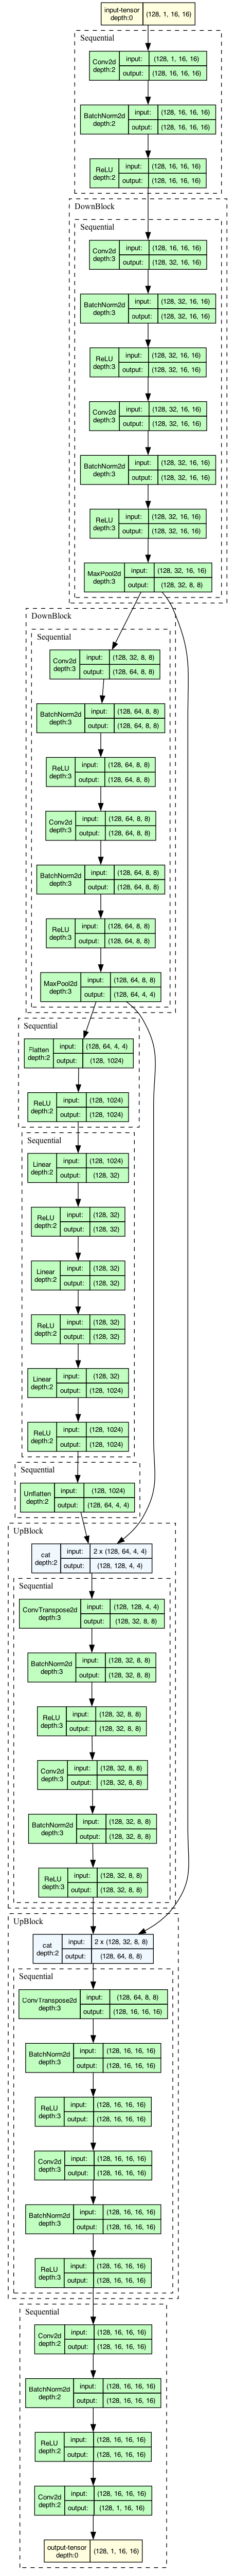

In [14]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(
    model,
    input_size=(BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE),
    device='meta',
    expand_nested=True
)
model_graph.resize_graph(scale=1.5)
model_graph.visual_graph

In [PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/), we can compile the model to make training faster. It will send the list of operations to our GPU so it can apply those operations to our inputs much like an assembly line. Read more about it [here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

In [15]:
model = torch.compile(UNet().to(device))